In [6]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:

# Custom Dataset pour les données sismiques
class SeismicDataset(Dataset):
    def __init__(self, snippets, magnitudes, transform=None):
        self.snippets = snippets
        self.magnitudes = magnitudes
        self.transform = transform

    def __len__(self):
        return len(self.snippets)

    def __getitem__(self, idx):
        snippet = self.snippets[idx]
        magnitude = self.magnitudes[idx]

        if self.transform:
            snippet = self.transform(snippet)

        return torch.FloatTensor(snippet).unsqueeze(0), torch.FloatTensor([magnitude])

In [3]:

# Architecture CNN pour signaux 3D (3 composantes sismiques)
class SeismicCNN(nn.Module):
    def __init__(self, input_length=500, n_channels=3):
        super(SeismicCNN, self).__init__()

        # Première couche convolutionnelle - capture les patterns haute fréquence
        self.conv1 = nn.Conv1d(n_channels, 32, kernel_size=15, stride=1, padding=7)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)

        # Deuxième couche - patterns moyens
        self.conv2 = nn.Conv1d(32, 64, kernel_size=11, stride=1, padding=5)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)

        # Troisième couche - patterns plus larges
        self.conv3 = nn.Conv1d(64, 128, kernel_size=7, stride=1, padding=3)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(2)

        # Couche de features plus complexes
        self.conv4 = nn.Conv1d(128, 256, kernel_size=5, stride=1, padding=2)
        self.bn4 = nn.BatchNorm1d(256)
        self.pool4 = nn.MaxPool1d(2)

        # Global Average Pooling pour réduire dimensionnalité
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Couches fully connected
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Régression - 1 sortie (magnitude)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Convolutions avec batch norm et pooling
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu(self.bn4(self.conv4(x))))

        # Global pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten

        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

In [4]:

class SeismicDatasetFromDF(Dataset):
    def __init__(self, df, target_length=500, scaler=None):
        self.df = df.reset_index(drop=True)
        self.target_length = target_length
        self.scaler = scaler

        # Debug: regarder la forme des snippets (une seule fois)
        if len(self.df) > 0:
            sample_snippet = self.df.iloc[0]['snippet']
            # print(f"Shape des snippets: {sample_snippet.shape}")

        # Calculer stats pour normalisation si pas de scaler fourni
        if self.scaler is None:
            print("Calcul des statistiques pour normalisation...")
            all_snippets = []
            for idx in range(0, min(1000, len(self.df))):  # Sample pour stats
                snippet = self._process_snippet(self.df.iloc[idx]['snippet'])
                all_snippets.append(snippet)

            # Assurer que c'est bien 2D pour les stats
            sample_data = np.vstack([s.flatten() for s in all_snippets])  # Flatten chaque sample

            # Normalisation simple : Z-score global
            self.mean = np.mean(sample_data)
            self.std = np.std(sample_data)

    def _process_snippet(self, snippet):
        # S'assurer que c'est un array numpy et gérer les 3 composantes
        snippet = np.array(snippet)

        if snippet.ndim == 2 and snippet.shape[0] == 3:
            # 3 composantes sismiques (Z, N, E) - les garder séparées
            processed_channels = []
            for channel in snippet:
                # Normaliser la longueur de chaque composante
                if len(channel) > self.target_length:
                    channel = channel[:self.target_length]
                elif len(channel) < self.target_length:
                    channel = np.pad(channel, (0, self.target_length - len(channel)), mode='constant')
                processed_channels.append(channel)
            return np.array(processed_channels)  # Shape: (3, target_length)
        else:
            # Fallback : flatten si format inattendu
            snippet = snippet.flatten()
            if len(snippet) > self.target_length:
                snippet = snippet[:self.target_length]
            elif len(snippet) < self.target_length:
                snippet = np.pad(snippet, (0, self.target_length - len(snippet)), mode='constant')
            return snippet.reshape(1, -1)  # Shape: (1, target_length)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        snippet = self._process_snippet(row['snippet'])
        magnitude = row['event_magnitude']

        # Normalisation simple
        if hasattr(self, 'mean') and hasattr(self, 'std'):
            snippet_normalized = (snippet - self.mean) / (self.std + 1e-8)
        elif self.scaler:
            # Utiliser le scaler des autres datasets
            snippet_normalized = (snippet - self.scaler.mean) / (self.scaler.std + 1e-8)
        else:
            snippet_normalized = snippet

        return torch.FloatTensor(snippet_normalized), torch.FloatTensor([magnitude])

In [5]:

def load_and_split_data(file_path, target_length=500, sample_rate=100):
    """
    Charge les données et crée les datasets sans tout stocker en mémoire
    """
    print("Chargement des données...")
    with open(file_path, 'rb') as f:
        df = pickle.load(f)

    # print(f"Dataset shape: {df.shape}")
    # print(f"Colonnes: {df.columns.tolist()}")

    # Filtrer par sampling rate
    df_filtered = df[df['sampling_rate'] == sample_rate].copy()
    print(f"Données avec sampling rate {sample_rate}: {len(df_filtered)} échantillons")

    # Split des indices plutôt que des données
    indices = np.arange(len(df_filtered))
    train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
    train_idx, val_idx = train_test_split(train_idx, test_size=0.25, random_state=42)

    print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

    # Créer les sous-dataframes
    df_train = df_filtered.iloc[train_idx].copy()
    df_val = df_filtered.iloc[val_idx].copy()
    df_test = df_filtered.iloc[test_idx].copy()

    # Créer le scaler sur le train set
    train_dataset = SeismicDatasetFromDF(df_train, target_length)

    # Passer les stats aux autres datasets
    class SimpleScaler:
        def __init__(self, mean, std):
            self.mean = mean
            self.std = std

    scaler = SimpleScaler(train_dataset.mean, train_dataset.std)

    # Créer les autres datasets avec le même scaler
    val_dataset = SeismicDatasetFromDF(df_val, target_length, scaler)
    test_dataset = SeismicDatasetFromDF(df_test, target_length, scaler)

    print(f"Magnitude range: {df_filtered['event_magnitude'].min():.2f} - {df_filtered['event_magnitude'].max():.2f}")

    return train_dataset, val_dataset, test_dataset, scaler

In [6]:

def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001):
    """
    Boucle d'entraînement du modèle
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0

        for snippets, magnitudes in train_loader:
            snippets, magnitudes = snippets.to(device), magnitudes.to(device)

            optimizer.zero_grad()
            outputs = model(snippets)
            loss = criterion(outputs, magnitudes)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for snippets, magnitudes in val_loader:
                snippets, magnitudes = snippets.to(device), magnitudes.to(device)
                outputs = model(snippets)
                loss = criterion(outputs, magnitudes)
                val_loss += loss.item()

        # Moyennes
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Sauvegarde du meilleur modèle
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_seismic_model.pth')

        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses

In [7]:

def evaluate_model(model, test_loader):
    """
    Évaluation du modèle sur le set de test avec analyse détaillée
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    predictions = []
    true_values = []

    with torch.no_grad():
        for snippets, magnitudes in test_loader:
            snippets, magnitudes = snippets.to(device), magnitudes.to(device)
            outputs = model(snippets)

            predictions.extend(outputs.cpu().numpy().flatten())
            true_values.extend(magnitudes.cpu().numpy().flatten())

    predictions = np.array(predictions)
    true_values = np.array(true_values)

    # Métriques de base
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predictions)

    # Métriques additionnelles
    residuals = true_values - predictions
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)

    # Analyse par gamme de magnitude
    magnitude_ranges = [(3.5, 4.5), (4.5, 5.5), (5.5, 6.5), (6.5, 7.5)]
    range_analysis = {}

    for min_mag, max_mag in magnitude_ranges:
        mask = (true_values >= min_mag) & (true_values < max_mag)
        if np.sum(mask) > 0:
            range_mae = mean_absolute_error(true_values[mask], predictions[mask])
            range_r2 = r2_score(true_values[mask], predictions[mask])
            range_analysis[f'{min_mag}-{max_mag}'] = {
                'count': np.sum(mask),
                'mae': range_mae,
                'r2': range_r2
            }

    # Pourcentage d'erreurs < seuils
    error_within_01 = np.mean(np.abs(residuals) < 0.1) * 100
    error_within_02 = np.mean(np.abs(residuals) < 0.2) * 100
    error_within_05 = np.mean(np.abs(residuals) < 0.5) * 100

    print(f"\n=== RÉSULTATS D'ÉVALUATION DÉTAILLÉS ===")
    print(f"📊 Métriques globales:")
    print(f"   MAE: {mae:.4f} magnitude")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   R²: {r2:.4f}")
    print(f"   Biais moyen: {mean_residual:.4f}")
    print(f"   Écart-type résidus: {std_residual:.4f}")

    print(f"\n🎯 Précision par seuils:")
    print(f"   Erreur < 0.1 mag: {error_within_01:.1f}%")
    print(f"   Erreur < 0.2 mag: {error_within_02:.1f}%")
    print(f"   Erreur < 0.5 mag: {error_within_05:.1f}%")

    print(f"\n🔍 Analyse par gamme:")
    for range_name, stats in range_analysis.items():
        print(f"   Mag {range_name}: {stats['count']} échantillons, MAE={stats['mae']:.3f}, R²={stats['r2']:.3f}")

    return predictions, true_values, {
        'mae': mae, 'rmse': rmse, 'r2': r2,
        'bias': mean_residual, 'residual_std': std_residual,
        'error_within_01': error_within_01,
        'error_within_02': error_within_02,
        'error_within_05': error_within_05,
        'range_analysis': range_analysis
    }

In [8]:

def plot_results(train_losses, val_losses, predictions, true_values, metrics):
    """
    Visualisation complète des résultats
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Courbes de loss
    axes[0,0].plot(train_losses, label='Training Loss', alpha=0.8)
    axes[0,0].plot(val_losses, label='Validation Loss', alpha=0.8)
    axes[0,0].set_xlabel('Epochs')
    axes[0,0].set_ylabel('Loss (MSE)')
    axes[0,0].set_title('Training & Validation Loss')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 2. Scatter plot prédictions vs vraies valeurs
    axes[0,1].scatter(true_values, predictions, alpha=0.6, s=20)
    axes[0,1].plot([true_values.min(), true_values.max()],
                   [true_values.min(), true_values.max()], 'r--', lw=2, label='Ligne parfaite')
    axes[0,1].set_xlabel('Magnitude Réelle')
    axes[0,1].set_ylabel('Magnitude Prédite')
    axes[0,1].set_title(f'Prédictions vs Vraies Valeurs (R²={metrics["r2"]:.3f})')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # 3. Distribution des résidus
    residuals = true_values - predictions
    axes[0,2].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
    axes[0,2].axvline(np.mean(residuals), color='red', linestyle='--',
                      label=f'Biais: {np.mean(residuals):.3f}')
    axes[0,2].set_xlabel('Résidus (Vrai - Prédit)')
    axes[0,2].set_ylabel('Fréquence')
    axes[0,2].set_title('Distribution des Résidus')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)

    # 4. Résidus vs valeurs prédites
    axes[1,0].scatter(predictions, residuals, alpha=0.6, s=20)
    axes[1,0].axhline(y=0, color='red', linestyle='--')
    axes[1,0].set_xlabel('Magnitude Prédite')
    axes[1,0].set_ylabel('Résidus')
    axes[1,0].set_title('Résidus vs Prédictions')
    axes[1,0].grid(True, alpha=0.3)

    # 5. Erreur absolue par magnitude
    abs_errors = np.abs(residuals)
    axes[1,1].scatter(true_values, abs_errors, alpha=0.6, s=20)
    axes[1,1].set_xlabel('Magnitude Réelle')
    axes[1,1].set_ylabel('Erreur Absolue')
    axes[1,1].set_title(f'Erreur Absolue par Magnitude (MAE={metrics["mae"]:.3f})')
    axes[1,1].grid(True, alpha=0.3)

    # 6. Barplot précision par seuils
    seuils = ['< 0.1', '< 0.2', '< 0.5']
    pourcentages = [metrics['error_within_01'], metrics['error_within_02'], metrics['error_within_05']]
    bars = axes[1,2].bar(seuils, pourcentages, alpha=0.7, color=['green', 'orange', 'blue'])
    axes[1,2].set_ylabel('Pourcentage (%)')
    axes[1,2].set_title('Précision par Seuil d\'Erreur')
    axes[1,2].grid(True, alpha=0.3)

    # Ajouter les valeurs sur les barres
    for bar, pct in zip(bars, pourcentages):
        axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                       f'{pct:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Résumé textuel
    print(f"\n🏆 RÉSUMÉ DE PERFORMANCE:")
    print(f"• En moyenne, erreur de ±{metrics['mae']:.2f} magnitude")
    print(f"• {metrics['error_within_02']:.0f}% des prédictions à ±0.2 magnitude")
    print(f"• {metrics['r2']*100:.1f}% de la variance expliquée")
    if abs(metrics['bias']) > 0.05:
        bias_dir = "surestimation" if metrics['bias'] > 0 else "sous-estimation"
        print(f"⚠️  Biais détecté: {bias_dir} systématique de {abs(metrics['bias']):.3f}")
    else:
        print("✅ Pas de biais significatif détecté")

Chargement des données...
Données avec sampling rate 50: 17773 échantillons
Train: 10663, Val: 3555, Test: 3555
Calcul des statistiques pour normalisation...
Magnitude range: 3.50 - 7.50
Modèle créé avec 287809 paramètres

=== DÉBUT DE L'ENTRAÎNEMENT ===
Epoch [0/100], Train Loss: 1.9236, Val Loss: 0.4058
Epoch [10/100], Train Loss: 0.3454, Val Loss: 0.2172
Epoch [20/100], Train Loss: 0.2032, Val Loss: 0.1661
Epoch [30/100], Train Loss: 0.1576, Val Loss: 0.1673
Epoch [40/100], Train Loss: 0.1416, Val Loss: 0.1747
Epoch [50/100], Train Loss: 0.1348, Val Loss: 0.1721
Epoch [60/100], Train Loss: 0.1313, Val Loss: 0.1795
Epoch [70/100], Train Loss: 0.1278, Val Loss: 0.1799
Epoch [80/100], Train Loss: 0.1288, Val Loss: 0.1910
Epoch [90/100], Train Loss: 0.1264, Val Loss: 0.1820

=== RÉSULTATS D'ÉVALUATION DÉTAILLÉS ===
📊 Métriques globales:
   MAE: 0.2950 magnitude
   RMSE: 0.4055
   R²: 0.0004
   Biais moyen: 0.0338
   Écart-type résidus: 0.4041

🎯 Précision par seuils:
   Erreur < 0.1 mag

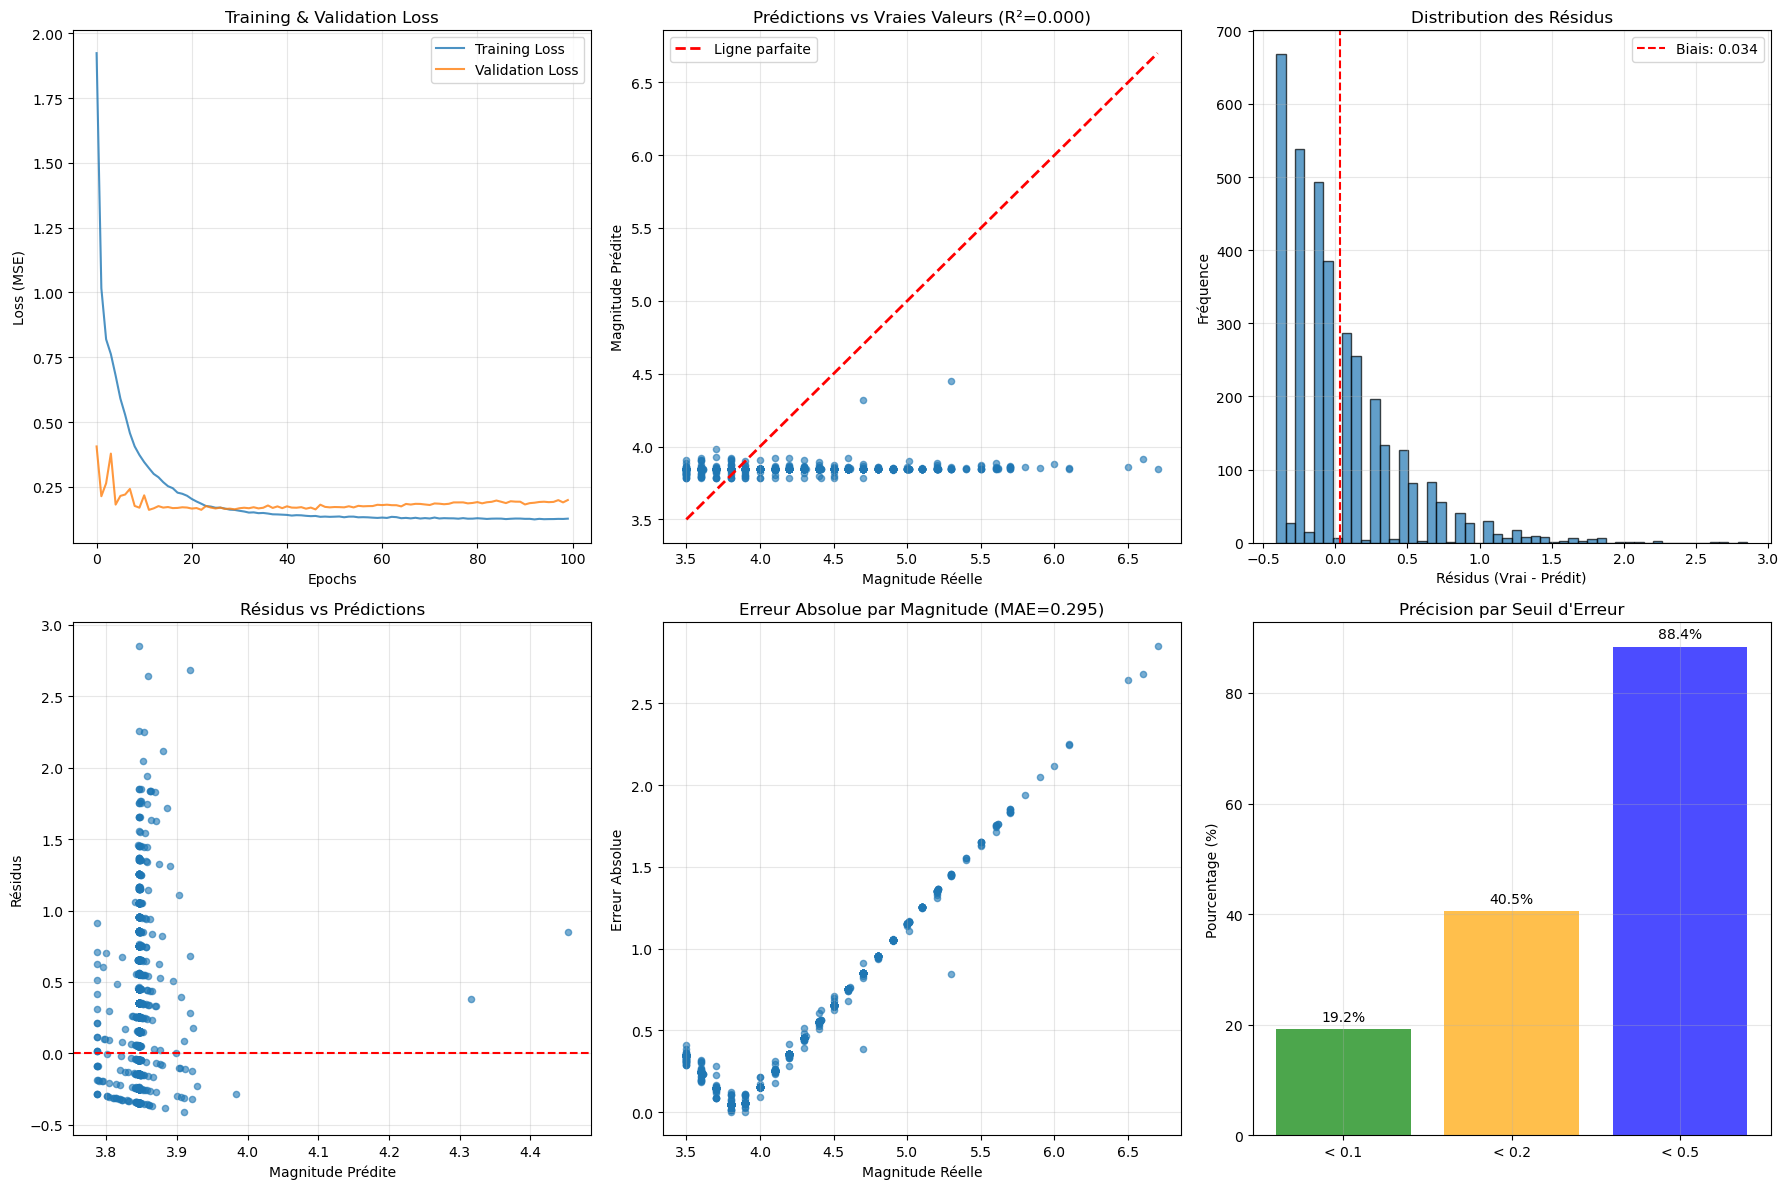


🏆 RÉSUMÉ DE PERFORMANCE:
• En moyenne, erreur de ±0.30 magnitude
• 41% des prédictions à ±0.2 magnitude
• 0.0% de la variance expliquée
✅ Pas de biais significatif détecté


In [9]:

# SCRIPT PRINCIPAL
if __name__ == "__main__":
    # Paramètres
    seconds = 5
    sample_rate = 50
    DATA_FILE = f"seismic_data_{seconds}_seconds_sampling_rate_{sample_rate}.pkl"
    TARGET_LENGTH = seconds * sample_rate  # 5 secondes * 100 Hz = 500
    BATCH_SIZE = 32
    NUM_EPOCHS = 100
    LEARNING_RATE = 0.001

    # 1. Chargement et création des datasets (memory-efficient)
    train_dataset, val_dataset, test_dataset, scaler = load_and_split_data(
        DATA_FILE, TARGET_LENGTH, sample_rate
    )

    # 2. Création des dataloaders

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 3. Création du modèle
    model = SeismicCNN(input_length=TARGET_LENGTH)
    print(f"Modèle créé avec {sum(p.numel() for p in model.parameters())} paramètres")

    # 4. Entraînement
    print("\n=== DÉBUT DE L'ENTRAÎNEMENT ===")
    train_losses, val_losses = train_model(model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE)

    # 5. Chargement du meilleur modèle et évaluation
    model.load_state_dict(torch.load('best_seismic_model.pth'))
    predictions, true_values, metrics = evaluate_model(model, test_loader)

    # 6. Visualisation
    plot_results(train_losses, val_losses, predictions, true_values, metrics)

In [10]:
# import pandas as pd
# import numpy as np
# import pickle
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# import matplotlib.pyplot as plt

import random

In [11]:

class SeismicAugmentation:
    def __init__(self, noise_factor=0.05, time_shift_max=20,
                 amplitude_scale_range=(0.8, 1.2), time_stretch_range=(0.95, 1.05)):
        self.noise_factor = noise_factor
        self.time_shift_max = time_shift_max
        self.amplitude_scale_range = amplitude_scale_range
        self.time_stretch_range = time_stretch_range

    def add_noise(self, signal):
        noise = np.random.normal(0, self.noise_factor * np.std(signal), signal.shape)
        return signal + noise

    def time_shift(self, signal):
        shift = random.randint(-self.time_shift_max, self.time_shift_max)
        if shift > 0:
            return np.pad(signal[:, :-shift], ((0, 0), (shift, 0)), mode='edge')
        elif shift < 0:
            return np.pad(signal[:, -shift:], ((0, 0), (0, -shift)), mode='edge')
        return signal

    def amplitude_scaling(self, signal):
        scale = random.uniform(*self.amplitude_scale_range)
        return signal * scale

    def augment(self, signal):
        aug_signal = signal.copy()
        if random.random() > 0.3: aug_signal = self.add_noise(aug_signal)
        if random.random() > 0.5: aug_signal = self.time_shift(aug_signal)
        if random.random() > 0.4: aug_signal = self.amplitude_scaling(aug_signal)
        return aug_signal

In [12]:

class SeismicDatasetFromDF(Dataset):
    def __init__(self, df, target_length=250, scaler=None, augment_rare=True):
        self.df = df.reset_index(drop=True)
        self.target_length = target_length
        self.scaler = scaler

        # Debug: regarder la forme des snippets (une seule fois)
        if len(self.df) > 0:
            sample_snippet = self.df.iloc[0]['snippet']
            print(f"Shape des snippets: {sample_snippet.shape}")

        # Calculer stats pour normalisation si pas de scaler fourni
        if self.scaler is None:
            print("Calcul des statistiques pour normalisation...")
            all_snippets = []
            for idx in range(0, min(1000, len(self.df))):  # Sample pour stats
                snippet = self._process_snippet(self.df.iloc[idx]['snippet'])
                all_snippets.append(snippet)

            # Assurer que c'est bien 2D pour les stats
            sample_data = np.vstack([s.flatten() for s in all_snippets])  # Flatten chaque sample

            # Normalisation simple : Z-score global
            self.mean = np.mean(sample_data)
            self.std = np.std(sample_data)

        self.augment_rare = augment_rare and scaler is None  # Seulement pour train
        if self.augment_rare:
            self.augmenter = SeismicAugmentation()
            self.rare_indices = list(df[df['event_magnitude'] >= 5.0].index)
            print(f"🔄 {len(self.rare_indices)} échantillons rares seront augmentés")

    def _process_snippet(self, snippet):
        # S'assurer que c'est un array numpy et gérer les 3 composantes
        snippet = np.array(snippet)

        if snippet.ndim == 2 and snippet.shape[0] == 3:
            # 3 composantes sismiques (Z, N, E) - les garder séparées
            processed_channels = []
            for channel in snippet:
                # Normaliser la longueur de chaque composante
                if len(channel) > self.target_length:
                    channel = channel[:self.target_length]
                elif len(channel) < self.target_length:
                    channel = np.pad(channel, (0, self.target_length - len(channel)), mode='constant')
                processed_channels.append(channel)
            return np.array(processed_channels)  # Shape: (3, target_length)
        else:
            # Fallback : flatten si format inattendu
            snippet = snippet.flatten()
            if len(snippet) > self.target_length:
                snippet = snippet[:self.target_length]
            elif len(snippet) < self.target_length:
                snippet = np.pad(snippet, (0, self.target_length - len(snippet)), mode='constant')
            return snippet.reshape(1, -1)  # Shape: (1, target_length)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        snippet = self._process_snippet(row['snippet'])
        magnitude = row['event_magnitude']

        # Normalisation simple
        if hasattr(self, 'mean') and hasattr(self, 'std'):
            snippet_normalized = (snippet - self.mean) / (self.std + 1e-8)
        elif self.scaler:
            # Utiliser le scaler des autres datasets
            snippet_normalized = (snippet - self.scaler.mean) / (self.scaler.std + 1e-8)
        else:
            snippet_normalized = snippet

        return torch.FloatTensor(snippet_normalized), torch.FloatTensor([magnitude])

In [13]:

class WeightedMSELoss(nn.Module):
    def __init__(self, magnitude_ranges=None, weights=None):
        super(WeightedMSELoss, self).__init__()

        # Définir les gammes de magnitude et leurs poids
        if magnitude_ranges is None:
            self.magnitude_ranges = [(3.5, 4.5), (4.5, 5.5), (5.5, 6.5), (6.5, 7.5)]
        else:
            self.magnitude_ranges = magnitude_ranges

        if weights is None:
            # Poids inversement proportionnels à la fréquence (approximative)
            self.weights = [1.0, 2.0, 5.0, 10.0]  # Plus c'est rare, plus c'est important
        else:
            self.weights = weights

        print(f"Weighted Loss - Gammes: {self.magnitude_ranges}")
        print(f"Weighted Loss - Poids: {self.weights}")

    def forward(self, predictions, targets):
        mse_loss = nn.MSELoss(reduction='none')
        losses = mse_loss(predictions.flatten(), targets.flatten())

        # Calculer les poids pour chaque échantillon
        weights = torch.ones_like(targets.flatten())

        for i, (min_mag, max_mag) in enumerate(self.magnitude_ranges):
            mask = (targets.flatten() >= min_mag) & (targets.flatten() < max_mag)
            weights[mask] = self.weights[i]

        # Appliquer les poids
        weighted_losses = losses * weights

        return weighted_losses.mean()


In [14]:
def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001, use_weighted_loss=True):
    """
    Boucle d'entraînement du modèle avec loss pondérée optionnelle
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Choisir la loss function
    if use_weighted_loss:
        criterion = WeightedMSELoss()
        print("🎯 Utilisation de la Weighted Loss pour gérer le déséquilibre")
    else:
        criterion = nn.MSELoss()
        print("📊 Utilisation de la MSE Loss standard")

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0

        for snippets, magnitudes in train_loader:
            snippets, magnitudes = snippets.to(device), magnitudes.to(device)

            optimizer.zero_grad()
            outputs = model(snippets)
            loss = criterion(outputs, magnitudes)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation (toujours avec MSE standard pour comparaison)
        model.eval()
        val_loss = 0.0
        val_criterion = nn.MSELoss()  # MSE standard pour validation

        with torch.no_grad():
            for snippets, magnitudes in val_loader:
                snippets, magnitudes = snippets.to(device), magnitudes.to(device)
                outputs = model(snippets)
                loss = val_criterion(outputs, magnitudes)
                val_loss += loss.item()

        # Moyennes
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Sauvegarde du meilleur modèle
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_seismic_model_weighted.pth')

        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses

In [15]:

def evaluate_model(model, test_loader):
    """
    Évaluation du modèle sur le set de test avec analyse détaillée
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    predictions = []
    true_values = []

    with torch.no_grad():
        for snippets, magnitudes in test_loader:
            snippets, magnitudes = snippets.to(device), magnitudes.to(device)
            outputs = model(snippets)

            predictions.extend(outputs.cpu().numpy().flatten())
            true_values.extend(magnitudes.cpu().numpy().flatten())

    predictions = np.array(predictions)
    true_values = np.array(true_values)

    # Métriques de base
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predictions)

    # Métriques additionnelles
    residuals = true_values - predictions
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)

    # Analyse par gamme de magnitude
    magnitude_ranges = [(3.5, 4.5), (4.5, 5.5), (5.5, 6.5), (6.5, 7.5)]
    range_analysis = {}

    for min_mag, max_mag in magnitude_ranges:
        mask = (true_values >= min_mag) & (true_values < max_mag)
        if np.sum(mask) > 0:
            range_mae = mean_absolute_error(true_values[mask], predictions[mask])
            range_r2 = r2_score(true_values[mask], predictions[mask])
            range_analysis[f'{min_mag}-{max_mag}'] = {
                'count': np.sum(mask),
                'mae': range_mae,
                'r2': range_r2
            }

    # Pourcentage d'erreurs < seuils
    error_within_01 = np.mean(np.abs(residuals) < 0.1) * 100
    error_within_02 = np.mean(np.abs(residuals) < 0.2) * 100
    error_within_05 = np.mean(np.abs(residuals) < 0.5) * 100

    print(f"\n=== RÉSULTATS D'ÉVALUATION DÉTAILLÉS ===")
    print(f"📊 Métriques globales:")
    print(f"   MAE: {mae:.4f} magnitude")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   R²: {r2:.4f}")
    print(f"   Biais moyen: {mean_residual:.4f}")
    print(f"   Écart-type résidus: {std_residual:.4f}")

    print(f"\n🎯 Précision par seuils:")
    print(f"   Erreur < 0.1 mag: {error_within_01:.1f}%")
    print(f"   Erreur < 0.2 mag: {error_within_02:.1f}%")
    print(f"   Erreur < 0.5 mag: {error_within_05:.1f}%")

    print(f"\n🔍 Analyse par gamme:")
    for range_name, stats in range_analysis.items():
        print(f"   Mag {range_name}: {stats['count']} échantillons, MAE={stats['mae']:.3f}, R²={stats['r2']:.3f}")

    return predictions, true_values, {
        'mae': mae, 'rmse': rmse, 'r2': r2,
        'bias': mean_residual, 'residual_std': std_residual,
        'error_within_01': error_within_01,
        'error_within_02': error_within_02,
        'error_within_05': error_within_05,
        'range_analysis': range_analysis
    }

In [16]:

def plot_results(train_losses, val_losses, predictions, true_values, metrics):
    """
    Visualisation complète des résultats
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Courbes de loss
    axes[0,0].plot(train_losses, label='Training Loss', alpha=0.8)
    axes[0,0].plot(val_losses, label='Validation Loss', alpha=0.8)
    axes[0,0].set_xlabel('Epochs')
    axes[0,0].set_ylabel('Loss (MSE)')
    axes[0,0].set_title('Training & Validation Loss')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 2. Scatter plot prédictions vs vraies valeurs
    axes[0,1].scatter(true_values, predictions, alpha=0.6, s=20)
    axes[0,1].plot([true_values.min(), true_values.max()],
                   [true_values.min(), true_values.max()], 'r--', lw=2, label='Ligne parfaite')
    axes[0,1].set_xlabel('Magnitude Réelle')
    axes[0,1].set_ylabel('Magnitude Prédite')
    axes[0,1].set_title(f'Prédictions vs Vraies Valeurs (R²={metrics["r2"]:.3f})')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # 3. Distribution des résidus
    residuals = true_values - predictions
    axes[0,2].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
    axes[0,2].axvline(np.mean(residuals), color='red', linestyle='--',
                      label=f'Biais: {np.mean(residuals):.3f}')
    axes[0,2].set_xlabel('Résidus (Vrai - Prédit)')
    axes[0,2].set_ylabel('Fréquence')
    axes[0,2].set_title('Distribution des Résidus')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)

    # 4. Résidus vs valeurs prédites
    axes[1,0].scatter(predictions, residuals, alpha=0.6, s=20)
    axes[1,0].axhline(y=0, color='red', linestyle='--')
    axes[1,0].set_xlabel('Magnitude Prédite')
    axes[1,0].set_ylabel('Résidus')
    axes[1,0].set_title('Résidus vs Prédictions')
    axes[1,0].grid(True, alpha=0.3)

    # 5. Erreur absolue par magnitude
    abs_errors = np.abs(residuals)
    axes[1,1].scatter(true_values, abs_errors, alpha=0.6, s=20)
    axes[1,1].set_xlabel('Magnitude Réelle')
    axes[1,1].set_ylabel('Erreur Absolue')
    axes[1,1].set_title(f'Erreur Absolue par Magnitude (MAE={metrics["mae"]:.3f})')
    axes[1,1].grid(True, alpha=0.3)

    # 6. Barplot précision par seuils
    seuils = ['< 0.1', '< 0.2', '< 0.5']
    pourcentages = [metrics['error_within_01'], metrics['error_within_02'], metrics['error_within_05']]
    bars = axes[1,2].bar(seuils, pourcentages, alpha=0.7, color=['green', 'orange', 'blue'])
    axes[1,2].set_ylabel('Pourcentage (%)')
    axes[1,2].set_title('Précision par Seuil d\'Erreur')
    axes[1,2].grid(True, alpha=0.3)

    # Ajouter les valeurs sur les barres
    for bar, pct in zip(bars, pourcentages):
        axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                       f'{pct:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Résumé textuel
    print(f"\n🏆 RÉSUMÉ DE PERFORMANCE:")
    print(f"• En moyenne, erreur de ±{metrics['mae']:.2f} magnitude")
    print(f"• {metrics['error_within_02']:.0f}% des prédictions à ±0.2 magnitude")
    print(f"• {metrics['r2']*100:.1f}% de la variance expliquée")
    if abs(metrics['bias']) > 0.05:
        bias_dir = "surestimation" if metrics['bias'] > 0 else "sous-estimation"
        print(f"⚠️  Biais détecté: {bias_dir} systématique de {abs(metrics['bias']):.3f}")
    else:
        print("✅ Pas de biais significatif détecté")

In [3]:


# Paramètres
seconds = 5
sample_rate = 100
DATA_FILE = f"seismic_data_{seconds}_seconds_sampling_rate_{sample_rate}.pkl"
TARGET_LENGTH = seconds * sample_rate  # 5 secondes * 100 Hz = 500
BATCH_SIZE = 32
NUM_EPOCHS = 100
LEARNING_RATE = 0.001

Chargement des données...
Données avec sampling rate 100: 12671 échantillons
Train: 7602, Val: 2534, Test: 2535
Shape des snippets: (3, 500)
Calcul des statistiques pour normalisation...
🔄 208 échantillons rares seront augmentés
Shape des snippets: (3, 500)
Shape des snippets: (3, 500)
Magnitude range: 3.50 - 7.50
Modèle créé avec 287809 paramètres

=== DÉBUT DE L'ENTRAÎNEMENT AVEC WEIGHTED LOSS ===
Weighted Loss - Gammes: [(3.5, 4.5), (4.5, 5.5), (5.5, 6.5), (6.5, 7.5)]
Weighted Loss - Poids: [1.0, 2.0, 5.0, 10.0]
🎯 Utilisation de la Weighted Loss pour gérer le déséquilibre
Epoch [0/100], Train Loss: 3.2399, Val Loss: 0.3931
Epoch [10/100], Train Loss: 0.8222, Val Loss: 0.2015
Epoch [20/100], Train Loss: 0.4976, Val Loss: 0.1461
Epoch [30/100], Train Loss: 0.3751, Val Loss: 0.1394
Epoch [40/100], Train Loss: 0.3180, Val Loss: 0.1307
Epoch [50/100], Train Loss: 0.3030, Val Loss: 0.1454
Epoch [60/100], Train Loss: 0.2790, Val Loss: 0.1329
Epoch [70/100], Train Loss: 0.2719, Val Loss: 0.

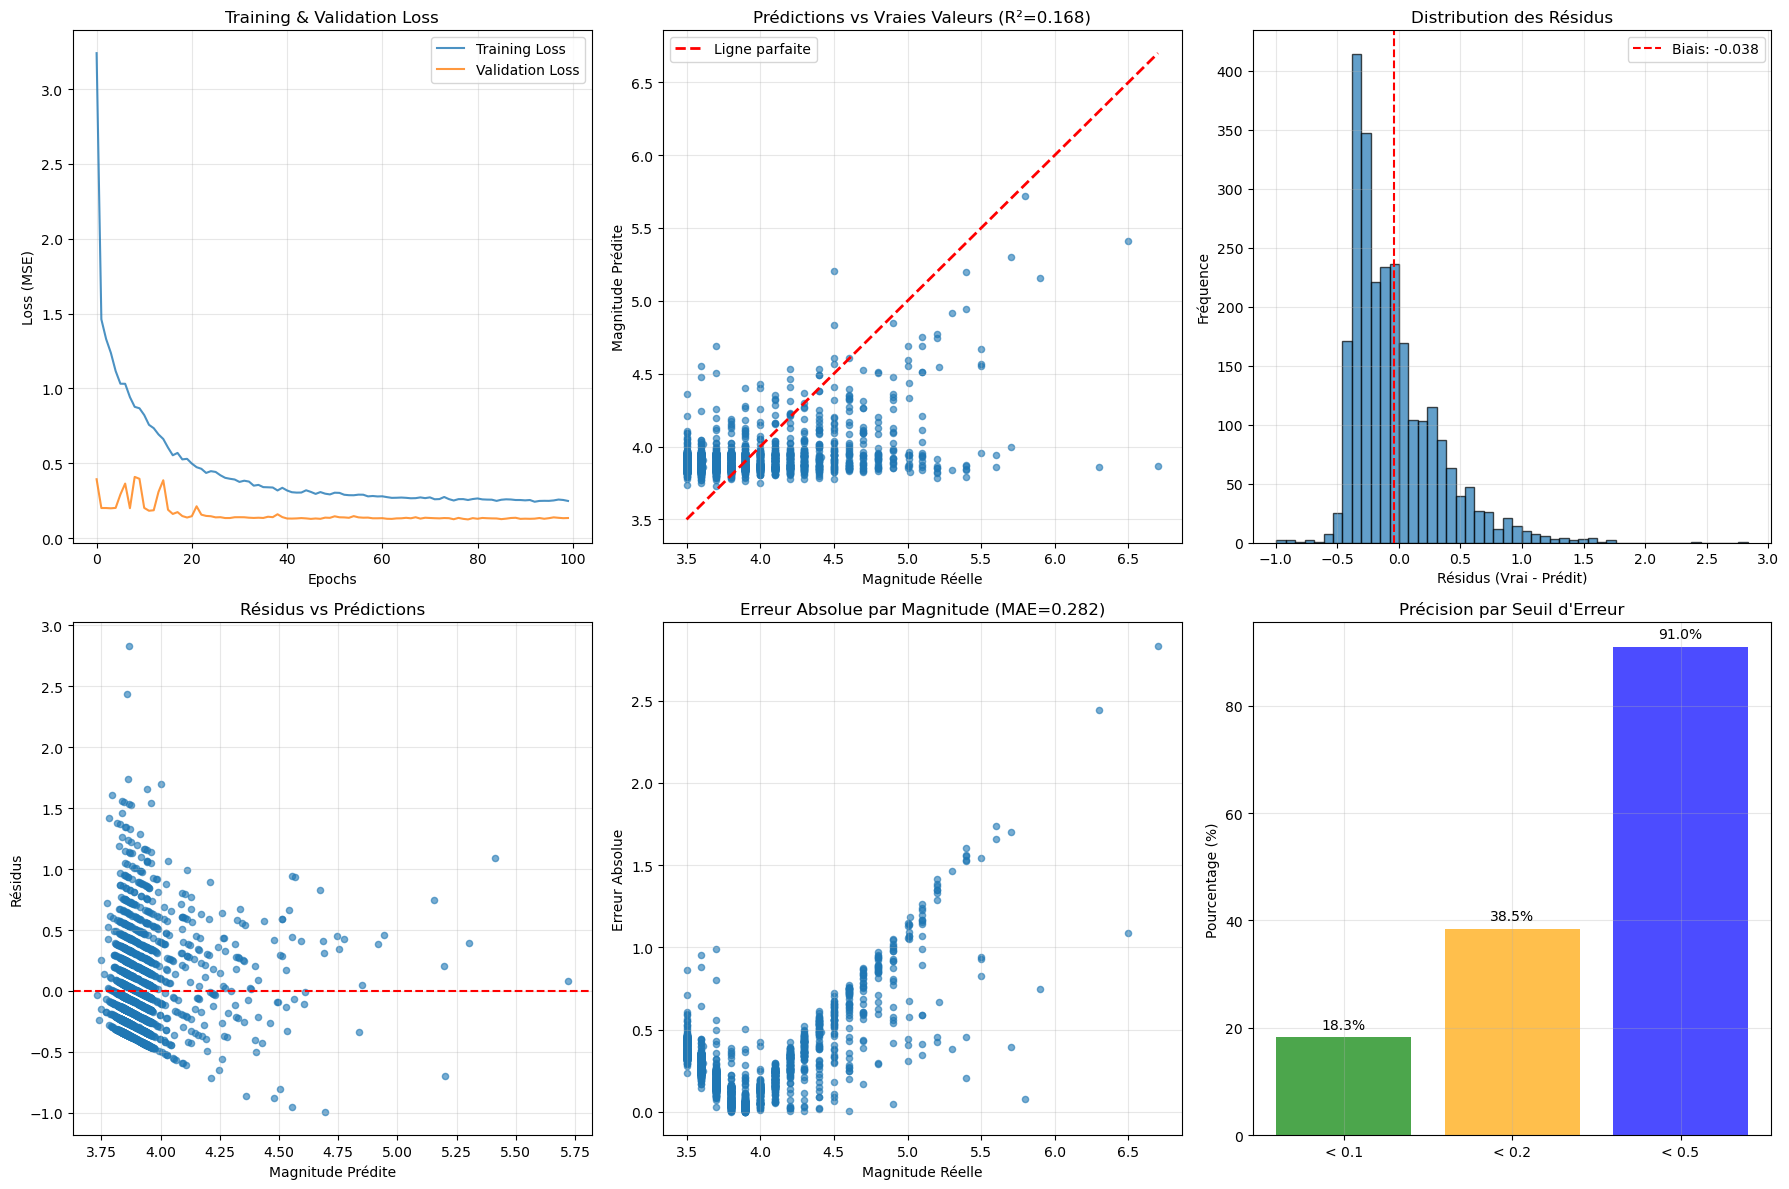


🏆 RÉSUMÉ DE PERFORMANCE:
• En moyenne, erreur de ±0.28 magnitude
• 38% des prédictions à ±0.2 magnitude
• 16.8% de la variance expliquée
✅ Pas de biais significatif détecté


In [17]:

# 1. Chargement et création des datasets (memory-efficient)
train_dataset, val_dataset, test_dataset, scaler = load_and_split_data(
    DATA_FILE, TARGET_LENGTH, sample_rate
)

# 2. Création des dataloaders

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 3. Création du modèle
model = SeismicCNN(input_length=TARGET_LENGTH)
print(f"Modèle créé avec {sum(p.numel() for p in model.parameters())} paramètres")

# 4. Entraînement avec weighted loss
print("\n=== DÉBUT DE L'ENTRAÎNEMENT AVEC WEIGHTED LOSS ===")
train_losses, val_losses = train_model(
    model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE, use_weighted_loss=True
)

# 5. Chargement du meilleur modèle et évaluation
model.load_state_dict(torch.load('best_seismic_model_weighted.pth'))
predictions, true_values, metrics = evaluate_model(model, test_loader)

# 6. Visualisation
plot_results(train_losses, val_losses, predictions, true_values, metrics)

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from obspy import read
import os

def plot_problematic_cases(samples, case_list, data_folder= "Turkey_data/DATA", problem_types=None):
    """
    Display specific problematic seismic samples for research presentations.

    Args:
        samples (list or DataFrame): Dataset samples (list of dicts or pandas DataFrame)
        case_list (list): List of (event_id, station) tuples
        data_folder (str): Path to .mseed files
        problem_types (list): Problem descriptions for each case
    """
    # Convert DataFrame to list of dicts if needed
    if hasattr(samples, 'to_dict'):  # It's a DataFrame
        samples = samples.to_dict('records')

    n_cases = len(case_list)
    fig, axes = plt.subplots(n_cases, 2, figsize=(16, 4 * n_cases))  # 2 columns: original + snippet
    if n_cases == 1:
        axes = axes.reshape(1, -1)  # Ensure 2D array even for single case

    # Colors for components
    colors = {"Z": "black", "N": "green", "E": "purple"}
    snippet_colors = {"Z": "blue", "N": "orange", "E": "red"}

    for idx, (event_id, station_name) in enumerate(case_list):
        ax_original = axes[idx, 0]  # Left subplot: original trace
        ax_snippet = axes[idx, 1]   # Right subplot: snippet

        # Find sample in dataset
        sample = None
        for s in samples:
            if s["event_id"] == event_id and s["station"] == station_name:
                sample = s
                break

        if sample is None:
            for ax in [ax_original, ax_snippet]:
                ax.text(0.5, 0.5, f"Sample not found:\nEvent {event_id}\nStation {station_name}",
                       ha='center', va='center', transform=ax.transAxes, color='red')
            continue

        snippet = sample["snippet"]
        magnitude = sample["event_magnitude"]
        distance_km = sample["distance_m"] / 1000

        # Load original traces
        try:
            original_path = os.path.join(data_folder, f"{event_id}.mseed")
            stream = read(original_path)
            station_traces = [tr for tr in stream if tr.stats.station == station_name]
            components = {tr.stats.channel[-1]: tr for tr in station_traces
                         if tr.stats.channel[-1] in ("Z", "N", "E")}
        except:
            for ax in [ax_original, ax_snippet]:
                ax.text(0.5, 0.5, f"Cannot load {event_id}.mseed",
                       ha='center', va='center', transform=ax.transAxes, color='red')
            continue

        # Plot ORIGINAL traces (left subplot)
        for comp in ["Z", "N", "E"]:
            if comp in components:
                tr = components[comp]
                times_full = np.linspace(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.npts)
                ax_original.plot(times_full, tr.data, color=colors[comp], label=f"Original {comp}")

        ax_original.set_title(f"Original Trace - Event {event_id}, Station {station_name}")
        ax_original.set_xlabel("Time (s)")
        ax_original.set_ylabel("Amplitude")
        ax_original.legend()
        ax_original.grid(True, alpha=0.3)

        # Plot SNIPPET (right subplot)
        snippet_duration = snippet.shape[1] / sample["sampling_rate"]
        times_snippet = np.linspace(0, snippet_duration, snippet.shape[1])

        for i, comp in enumerate(["Z", "N", "E"]):
            ax_snippet.plot(times_snippet, snippet[i], color=snippet_colors[comp],
                           linewidth=2, label=f"Snippet {comp}")

        problem_desc = problem_types[idx] if problem_types and idx < len(problem_types) else "Issue"
        ax_snippet.set_title(f"{problem_desc} - Snippet (Mag {magnitude:.1f})")
        ax_snippet.set_xlabel("Time (s)")
        ax_snippet.set_ylabel("Amplitude")
        ax_snippet.legend()
        ax_snippet.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

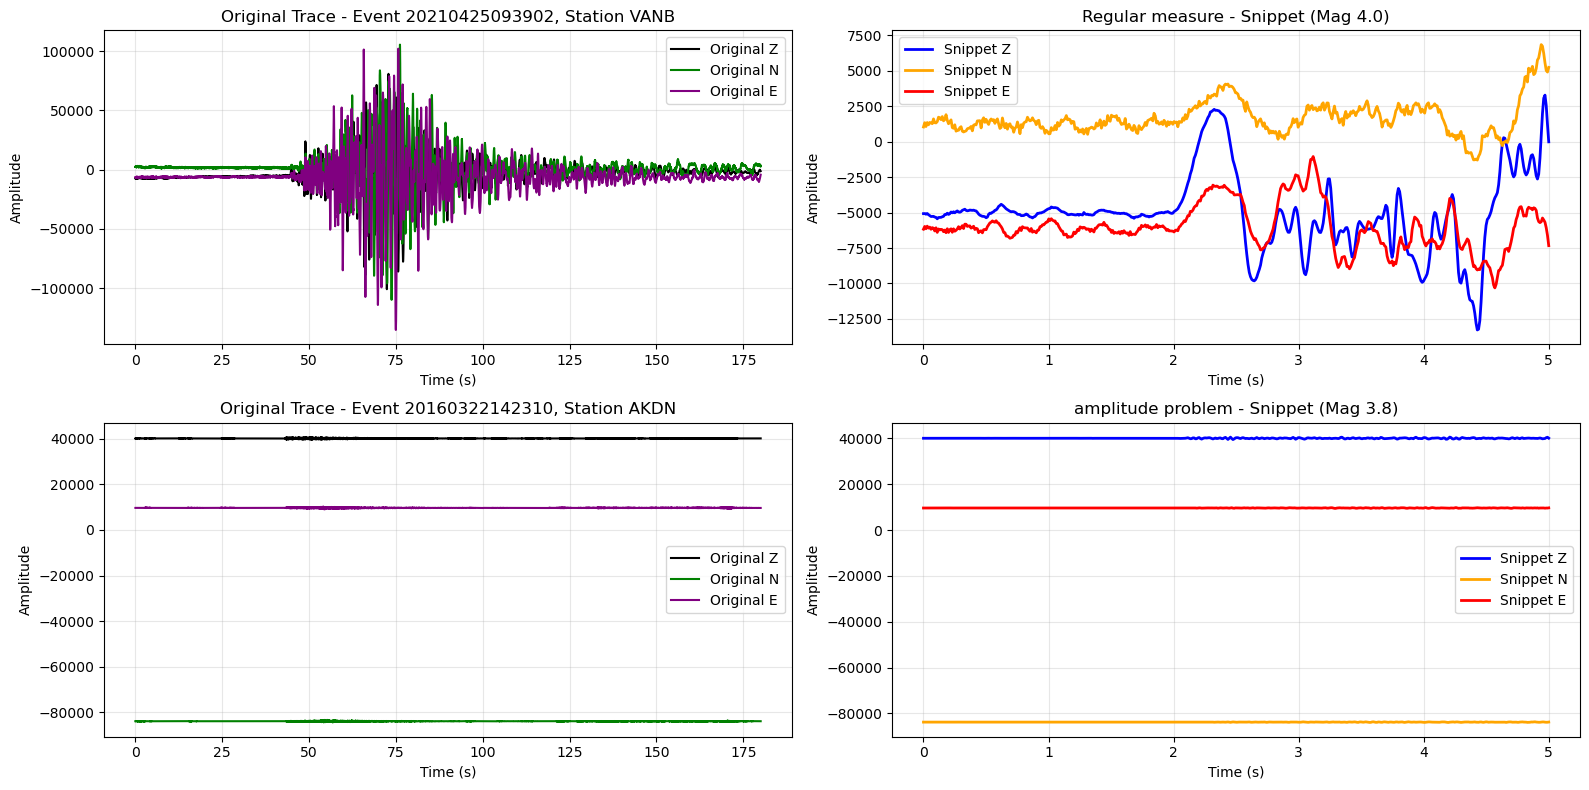

In [19]:
# Displaying sample: Event 20210425093902 at Station VANB

# Displaying sample: Event 20160322142310 at Station AKDN


# Tes cas problématiques
cases = [
    ("20210425093902", "VANB"),
    ("20160322142310", "AKDN")
]

problems = [
    "Regular measure",
    "amplitude problem"
]

with open(DATA_FILE, 'rb') as f:
        dataset = pickle.load(f)
plot_problematic_cases(dataset, cases, data_folder="Turkey_data/DATA", problem_types=problems)